#### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
from scipy import stats
from scipy.signal import lfilter 

from math import sqrt as mathsqrt
from math import log as mathlog 

from gym import Env
from gym.spaces import Discrete, Box

import torch as T
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.optim as optim

import os
import pickle

import logging
logger = logging.getLogger('pymc3') 
logger.setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

Mounted at /content/drive


#### Run network on CUDA (GPU)

In [2]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

#### SDOF oscilator custom gym environment

In [3]:
class sdofEnv(Env):
    def __init__(self, mass, K0, omegaNoise, muA, muB, numSteps = 20, coeffVarA=0.5, coeffVarB=0.3, costReplace=10000, damageFailThress=0.2):

        # Problem data
        self.K0 = K0
        self.mass = mass
        self.omegaNoise = omegaNoise
        self.muA = muA
        self.sigmaA = self.muA * coeffVarA
        self.muB = muB
        self.sigmaB = self.muB * coeffVarB

        self.logMuA = mathlog(self.muA**2/mathsqrt(self.muA**2+self.sigmaA**2))
        self.logSigmaA = mathsqrt(mathlog(1+self.sigmaA**2/self.muA**2))
 
        self.numSteps = numSteps
        self.action_space = Discrete(3) # 0: do nothing, 1: repair, 2: replace
        self.observation_space = Box(-np.inf, np.inf, shape=(6,), dtype=np.float32) # mean, variance, skewness, kurtosis, decision step, component age
        
        # Costs
        self.costReplace = -1 * costReplace
        self.costPartialRepair = 0.5 * self.costReplace
        self.costFailure = 2 * self.costReplace

        self.failThres = damageFailThress

        # Reset the environment
        self.reset()

    def step(self, action):

        # Bayesian inference
        # Updating the distributions of A, B
        self._bayesian_inference()

        # np array with the damage samples that form the posterior distribution
        npDamages = self.trace['Damage']

        
        failProb = self._calc_risk(npDamages)
        reward = failProb * self.costFailure

        if action == 0: # do nothing
            pass
        elif action == 1: # repair, go back to age steps
            self.age = max(0, self.age - 2)
            reward += self.costPartialRepair
            # self.K = min(self.K0, self.K + 0.2 * self.K0)
        elif action == 2: # replace, restore age to 0
            self.age = 0
            reward += self.costReplace
            # self.K = self.K0
        else:
            print('Invalid action was given as input. Possible actions:\n0: do nothing\n1: repair\n2: replace')

        self.state = np.array([npDamages.mean(), npDamages.var(), stats.skew(npDamages), stats.kurtosis(npDamages), self.age, self.decisionStep], dtype=np.float32)

        self.age += 1
        self.decisionStep += 1
        
        done = True if self.decisionStep == self.numSteps else False
        info = {}

        return self.state, reward, done, info
    
    def _calc_risk(self, damages): # Damages is an 1D numpy array containing the samples that were generated through NUTS
        return (damages >= self.failThres).sum() / damages.shape[0]


    def _bayesian_inference(self, draws=4000, tune=2000, targetAccept=0.9):
    
        with pm.Model() as bayesianInference:

            if self.age == 0:
                A = pm.Lognormal('A', mu=self.logMuA, sigma=self.logSigmaA)
                B = pm.Normal('B', mu=self.muB, sigma=self.sigmaB)
                a_sample = np.random.lognormal(mean=self.logMuA, sigma=self.logSigmaA)
                b_sample = np.random.normal(loc=self.muB, scale=self.sigmaB)
            else:
                A = self._from_posterior('A', self.trace['A'])
                B = self._from_posterior('B', self.trace['B'])
                a_sample = np.random.choice(self.trace['A'])
                b_sample = np.random.choice(self.trace['B'])
                
            Damage = pm.Deterministic('Damage', A * (self.age+1)**B)

            tempDamage = a_sample * (self.age + 1)**b_sample
            K = self.K0/(1+tempDamage)

            muOmega = mathsqrt(K/self.mass)

            obsOmega = np.random.normal(loc=muOmega, scale=self.omegaNoise*muOmega)
            expectedOmega = pm.math.sqrt(K/self.mass)

            observedOmega = pm.Normal('omega_obs', mu=expectedOmega, sigma=self.omegaNoise*muOmega, observed=obsOmega)
            
            self.trace = pm.sample(draws=draws, tune=tune, target_accept=targetAccept, progressbar=False)

    def _from_posterior(self, param, samples):
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)

        return pm.distributions.Interpolated(param, x, y)   

    def reset(self):
        self.decisionStep = 0
        self._new_comp()

        return self.state
    
    def _new_comp(self):
        self.age = 0
        # state is a list with 6 items i.e. mean, variance, skewness, kurtosis, and the two time variables
        self.state = np.array([0, 0, 0, 0, self.age, self.decisionStep], dtype=np.float32)

    def render(self):
        pass

    def close(self):
        pass

#### PPO minibatch memory

In [4]:
class PPOMemory:
    def __init__(self, input_dims, steps_per_epoch, gamma=0.99, lam=0.95):
        self.states = np.zeros((steps_per_epoch, input_dims), dtype=np.float32)
        self.probs = np.zeros(steps_per_epoch, dtype=np.float32)
        self.vals = np.zeros(steps_per_epoch, dtype=np.float32)
        self.actions = np.zeros(steps_per_epoch, dtype=np.int32)
        self.rewards = np.zeros(steps_per_epoch, dtype=np.float32)
        self.returns = np.zeros(steps_per_epoch, dtype=np.float32)
        self.advantages = np.zeros(steps_per_epoch, dtype=np.float32)

        self.gamma, self.lam = gamma, lam
        self.mem_cntr, self.start_ind = 0, 0

    def store_memory(self, state, action, probs, vals, reward):
        self.states[self.mem_cntr] = state
        self.actions[self.mem_cntr] = action
        self.probs[self.mem_cntr] = probs
        self.vals[self.mem_cntr] = vals
        self.rewards[self.mem_cntr] = reward

        self.mem_cntr += 1
    
    def finish_path(self, last_val=0):
        path_slice = slice(self.start_ind, self.mem_cntr)
        rewards = np.append(self.rewards[path_slice], last_val)
        values = np.append(self.vals[path_slice], last_val)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantages[path_slice] = self._discounted_cumulative_sums(deltas, self.gamma * self.lam)
        self.returns[path_slice] = self._discounted_cumulative_sums(rewards, self.gamma)[:-1]

        self.start_ind = self.mem_cntr

    def _discounted_cumulative_sums(self, x, discount):
        return lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

#### Actor neural network

In [5]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha, chkpt_dir, fc1_dims=256, fc2_dims=256):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, f"ppo_toy_actor")

        self.actor = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
            nn.Softmax(dim=-1),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
    
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file, map_location=device))

#### Critic neural network

In [6]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, chkpt_dir, fc1_dims=256, fc2_dims=256):

        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, f"ppo_toy_critic")

        self.critic = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        value = self.critic(state)

        return value
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
    
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file, map_location=device))

#### PPO Agent

In [13]:
class PPOAgent:
    def __init__(self, n_actions, input_dims, steps_per_epoch, chkpt_dir, gamma=0.99, pi_lr=3e-4, v_lr=1e-3, gae_lambda=0.95, policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

        self.checkpoint_dir = chkpt_dir

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

        self.actor = ActorNetwork(n_actions, input_dims, pi_lr, chkpt_dir)
        self.critic = CriticNetwork(input_dims, v_lr, chkpt_dir)
        self.memory = PPOMemory(input_dims, steps_per_epoch, gamma, gae_lambda)

    def remember(self, state, action, probs, vals, reward):
        self.memory.store_memory(state, action, probs, vals, reward)

    def choose_action(self, observation):
        state = T.tensor(np.array([observation]), dtype=T.float).to(device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        self._normalize_advantages()
        advantages = T.tensor(self.memory.advantages).to(device)
        returns = T.tensor(self.memory.returns).to(device)

        for _ in range(self.n_epochs):

            permutation = T.randperm(self.steps_per_epoch)

            for i in range(0, self.steps_per_epoch, self.batch_size):
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()

                indices = permutation[i:i+self.batch_size]
                
                states = T.tensor(self.memory.states[indices], dtype=T.float).to(device)
                old_probs = T.tensor(self.memory.probs[indices]).to(device)
                actions = T.tensor(self.memory.actions[indices]).to(device)

                critic_values = self.critic(states)
                critic_values = T.squeeze(critic_values)

                dist = self.actor(states)
                new_probs = dist.log_prob(actions)

                actor_loss = self._comp_pi_loss(old_probs, new_probs, advantages[indices])
                critic_loss = self._comp_v_loss(returns[indices], critic_values)
                
                actor_loss.backward()
                critic_loss.backward()
                
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.mem_cntr, self.memory.start_ind = 0, 0
    
    def _comp_pi_loss(self, old_pi, new_pi, advs):
        prob_ratio = new_pi.exp() / old_pi.exp()
        weighted_probs = advs * prob_ratio
        weighted_clipped_probs = (T.clamp(prob_ratio, 1 - self.policy_clip, 1 + self.policy_clip) * advs)
        actor_loss = - T.min(weighted_probs, weighted_clipped_probs).mean()
        return actor_loss
    
    def _comp_v_loss(self, rets, vs):
        return ((rets - vs)**2).mean()
    
    def _normalize_advantages(self):
        self.memory.mem_cntr, self.memory.start_ind = 0, 0
        advantage_mean, advantage_std = (np.mean(self.memory.advantages), np.std(self.memory.advantages))

        self.memory.advantages = (self.memory.advantages - advantage_mean) / advantage_std
    
    def save_training(self, episodeScores, iterationScores):
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
        with open(os.path.join(self.checkpoint_dir, "ppo_scores"), "wb") as f:
            pickle.dump((episodeScores, iterationScores), f)
        
    def load_training(self):
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        with open(os.path.join(self.checkpoint_dir, "ppo_scores"), "rb") as f:
            episodeScores, iterationScores = pickle.load(f)
        
        return episodeScores, iterationScores

<h4> Policy Realization function

In [14]:
def policy_realization(agent, env):
    actions = np.zeros(env.numSteps)
    states = np.zeros((env.numSteps+1, env.observation_space.shape[0]-2))
    observation = env.reset()
    cost = 0
    states[0] = observation[:-2]

    for decStep in range(env.numSteps):
        action, _, _ = agent.choose_action(observation)
        observation_, reward, _, _ = env.step(action)
        cost += reward
        actions[decStep] = action

        observation = observation_
        states[1 + decStep] = observation[:-2]
    
    return cost, actions, states

#### Hyperparameters

In [15]:
steps_per_epoch = 200
batch_size = 8
n_epochs = 10
gamma = 0.99
clip_ratio = 0.2
policy_lr = 3e-4
value_func_lr = 1e-3
lam = 0.95

train_iters = 1
checkpoint_dir = "F:/Uni/Thesis/Code/current/ToyProblem/Refactored/savedModels/PPO"

#### Problem data

In [16]:
muA = 8e-3
sigmaA = muA * 0.5
muB = 1.8
sigmaB = muB * 0.3

mass = 10
K0 = 200
omegaNoise = 0.1 # coefficient of variation, meaning that sigma = omegaNoise * mu

env = sdofEnv(mass=mass, K0=K0, omegaNoise=omegaNoise, muA=muA, muB=muB)

```continue_flag```  serves the purpose of training the agent in batches. <br>

Training for the needed episodes in a single run would have been impossible (due to excessive runtime).<br>

Therefore, the neural net and the computed rewards are saved and reloaded.

In [17]:
continue_flag = False

In [ ]:
agent = PPOAgent(env.action_space.n, env.observation_space.shape[0], steps_per_epoch, checkpoint_dir, gamma, policy_lr, value_func_lr, lam, clip_ratio, batch_size, n_epochs)

observation, episode_return, episode_length = env.reset(), 0, 0

if continue_flag:
    iterScore, episode_score = agent.load_training()
else:
    iterScore, episode_score = [], []

for i in range(train_iters):
    
    sum_return = 0
    num_episodes = 0
    
    for t in range(steps_per_epoch):

        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        
        episode_return += reward
        
        agent.remember(observation, action, prob, val, reward)

        observation = observation_

        if done or (t == steps_per_epoch - 1):
            last_val = 0 if done else agent.critic(T.tensor(observation).to(agent.actor.device)).item()
            agent.memory.finish_path(last_val)
            sum_return += episode_return
            num_episodes += 1
            if done: episode_score.append(episode_return)
            observation, episode_return, episode_length = env.reset(), 0, 0
        

    agent.learn()
    tempScore = sum_return / num_episodes
    iterScore.append(tempScore)
    print(f"Iteration {i+1}, Average score {tempScore :.2f}")

clear_output(wait=True)
print("PPO ran succesfully")
agent.save_training(episode_score, iterScore)
print("Training data saved successfully")

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


<h4> Plot learning (rewards over episodes)

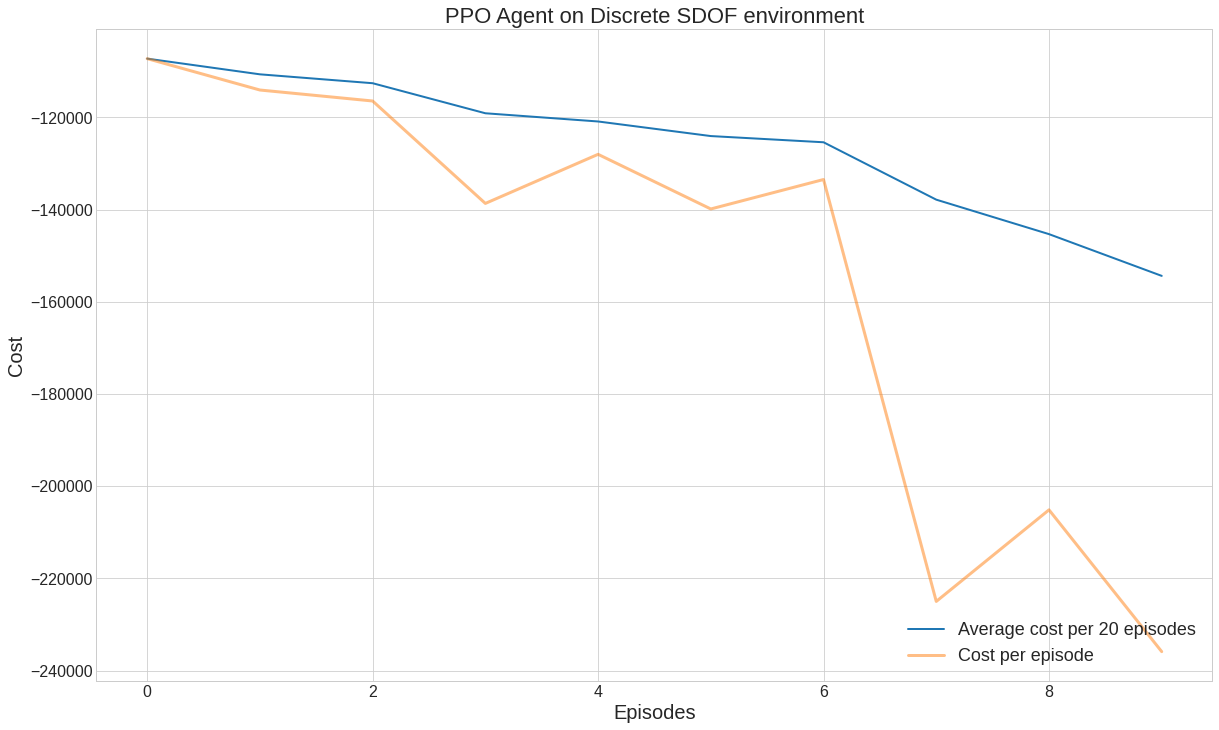

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(20,12))
avg_ppo_scores = [np.mean(episode_score[max(0, i - 10):(i + 1)]) for i in range(len(episode_score))]
plt.plot(list(range(len(avg_ppo_scores))), avg_ppo_scores, label='average reward per 50 episodes', linewidth=2)
plt.plot(list(range(len(episode_score))), episode_score, label='reward per episode', linewidth=3, alpha=0.5)
plt.legend(fontsize=18, loc='lower right')
plt.xlabel('Episodes', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('PPO Agent on Discrete SDOF environment', fontsize=22)
plt.show()